Розмір тренувальної вибірки: 60
Розмір валідаційної вибірки: 20
Розмір тестової вибірки: 20


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Оптимальна архітектура: (8,)


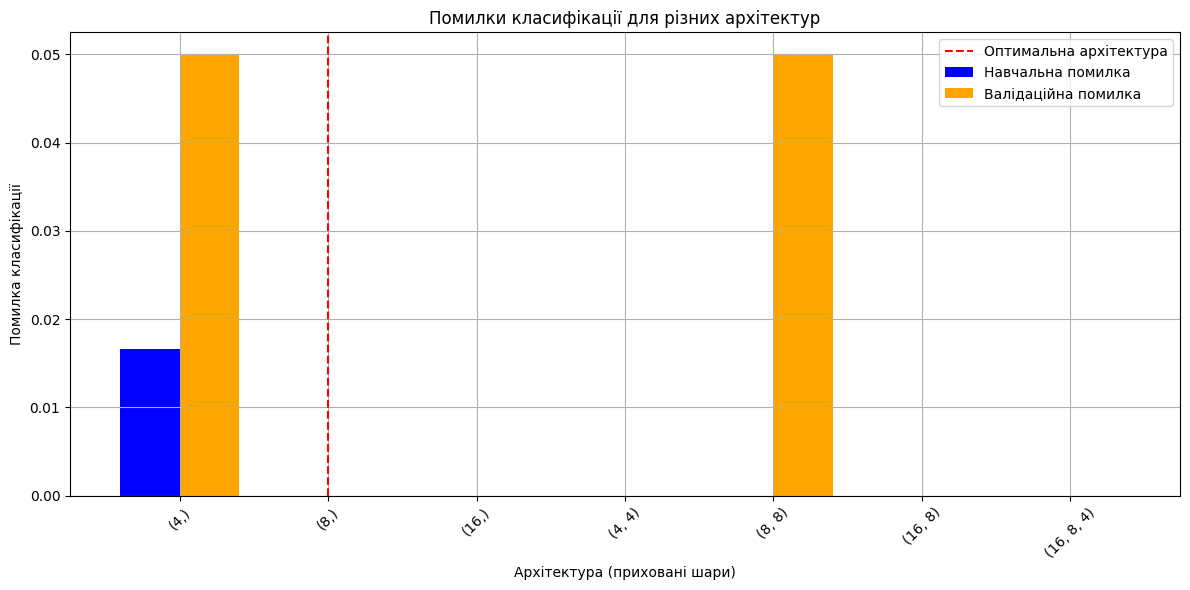

Оптимальне значення регуляризації (alpha): 0


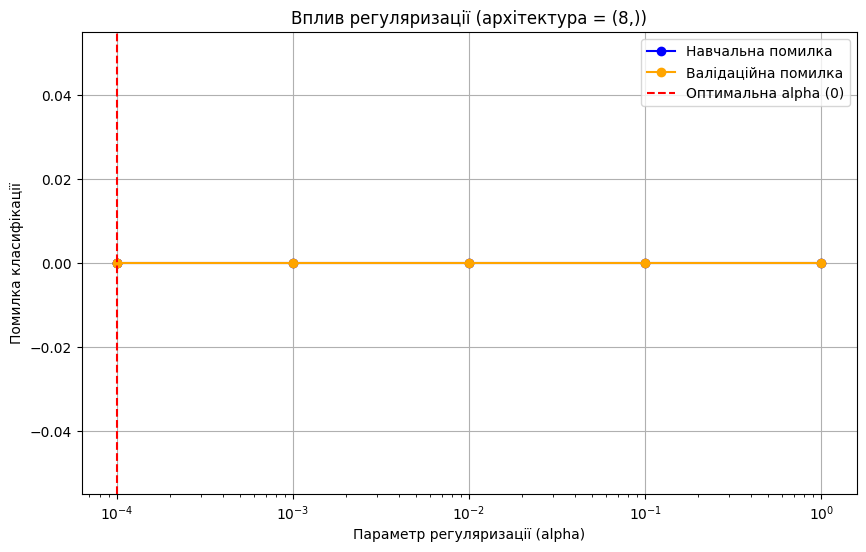

Помилка на тестовій вибірці: 0.000000


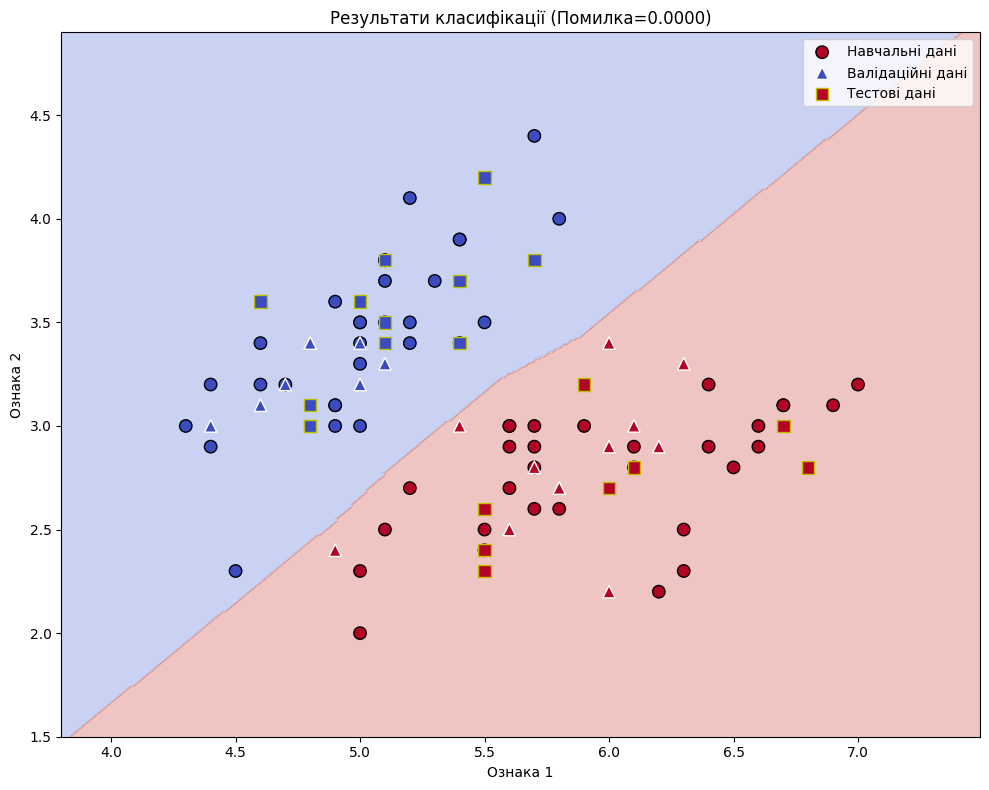

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# -------------------- Функції для генерації/завантаження даних --------------------

def generate_regression_data(degree=2, noise=0.3, num_samples=100, seed=42):
    """
    Генерує синтетичні дані для регресії із заданим ступенем полінома та шумом

    Args:
        degree: Ступінь полінома для генерації даних
        noise: Рівень шуму (стандартне відхилення)
        num_samples: Кількість точок даних
        seed: Зерно для генератора випадкових чисел

    Returns:
        X: Матриця ознак (n_samples, 1)
        y: Вектор цільових значень (n_samples, 1)
        y_true: Вектор справжніх цільових значень без шуму (n_samples, 1)
    """
    np.random.seed(seed)
    X = np.linspace(0, 10, num_samples).reshape(-1, 1)

    # Генеруємо цільові значення як поліном заданого ступеня
    coefficients = np.random.randn(degree + 1)
    y_true = np.zeros_like(X)

    for i in range(degree + 1):
        y_true += coefficients[i] * (X ** i)

    # Додаємо шум
    y = y_true + noise * np.random.randn(num_samples, 1)

    return X, y, y_true

def load_iris_binary():
    """
    Завантажує набір даних Iris для бінарної класифікації (лише два класи)

    Returns:
        X: Матриця ознак (n_samples, 2)
        y: Вектор цільових значень (n_samples,)
    """
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # беремо тільки перші дві ознаки для спрощення
    y = iris.target
    # Відбираємо тільки два класи
    X = X[y != 2]
    y = y[y != 2]
    return X, y

# -------------------- Функції для оцінки якості моделей --------------------

def compute_mse(y_true, y_pred):
    """
    Обчислює середньоквадратичну помилку

    Args:
        y_true: Справжні значення
        y_pred: Передбачені значення

    Returns:
        mse: Середньоквадратична помилка
    """
    # Convert inputs to numpy arrays and ensure they're flattened
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Use vectorized operations instead of loop
    m = len(y_true)
    error = np.sum((y_pred - y_true)**2)
    return float(error / (2 * m))  # Explicitly return a float

def compute_classification_error(y_true, y_pred):
    """
    Обчислює помилку класифікації

    Args:
        y_true: Справжні мітки класів
        y_pred: Передбачені мітки класів

    Returns:
        error: Доля неправильно класифікованих прикладів
    """
    m = len(y_true)
    incorrect = 0
    for i in range(m):
        if y_pred[i] != y_true[i]:
            incorrect += 1
    return incorrect / m

# -------------------- Функції для навчання моделей різної складності --------------------

def train_polynomial_models(X_train, y_train, X_cv, y_cv, max_degree=10):
    """
    Навчає поліноміальні моделі різного ступеня і повертає помилки

    Args:
        X_train: Навчальні дані (ознаки)
        y_train: Навчальні дані (цільові значення)
        X_cv: Валідаційні дані (ознаки)
        y_cv: Валідаційні дані (цільові значення)
        max_degree: Максимальний ступінь поліному для навчання

    Returns:
        train_errors: Помилки на навчальній вибірці
        cv_errors: Помилки на валідаційній вибірці
    """
    train_errors = np.zeros(max_degree)
    cv_errors = np.zeros(max_degree)

    for degree in range(1, max_degree + 1):
        # Створення поліноміальних ознак
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_cv_poly = poly.transform(X_cv)

        # Створення та навчання моделі
        model = Ridge(alpha=1e-10) if degree > 5 else LinearRegression()
        model.fit(X_train_poly, y_train)

        # Обчислення помилок
        y_train_pred = model.predict(X_train_poly)
        y_cv_pred = model.predict(X_cv_poly)

        train_errors[degree-1] = compute_mse(y_train, y_train_pred)
        cv_errors[degree-1] = compute_mse(y_cv, y_cv_pred)

    return train_errors, cv_errors

def train_regularized_models(X_train, y_train, X_cv, y_cv, degree=5, lambda_range=None):
    """
    Навчає регуляризовані моделі з різними значеннями lambda і повертає помилки

    Args:
        X_train: Навчальні дані (ознаки)
        y_train: Навчальні дані (цільові значення)
        X_cv: Валідаційні дані (ознаки)
        y_cv: Валідаційні дані (цільові значення)
        degree: Ступінь поліному
        lambda_range: Список значень lambda для регуляризації

    Returns:
        train_errors: Помилки на навчальній вибірці
        cv_errors: Помилки на валідаційній вибірці
        lambda_range: Використані значення lambda
    """
    if lambda_range is None:
        lambda_range = [1e-10, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

    train_errors = np.zeros(len(lambda_range))
    cv_errors = np.zeros(len(lambda_range))

    # Створення поліноміальних ознак
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_cv_poly = poly.transform(X_cv)

    for i, lambda_val in enumerate(lambda_range):
        # Створення та навчання регуляризованої моделі
        model = Ridge(alpha=lambda_val)
        model.fit(X_train_poly, y_train)

        # Обчислення помилок
        y_train_pred = model.predict(X_train_poly)
        y_cv_pred = model.predict(X_cv_poly)

        train_errors[i] = compute_mse(y_train, y_train_pred)
        cv_errors[i] = compute_mse(y_cv, y_cv_pred)

    return train_errors, cv_errors, lambda_range

def train_neural_networks(X_train, y_train, X_cv, y_cv, hidden_layers_list=None):
    """
    Навчає нейронні мережі з різною архітектурою і повертає помилки

    Args:
        X_train: Навчальні дані (ознаки)
        y_train: Навчальні дані (цільові значення)
        X_cv: Валідаційні дані (ознаки)
        y_cv: Валідаційні дані (цільові значення)
        hidden_layers_list: Список архітектур прихованих шарів

    Returns:
        train_errors: Помилки на навчальній вибірці
        cv_errors: Помилки на валідаційній вибірці
        hidden_layers_list: Використані архітектури
    """
    if hidden_layers_list is None:
        hidden_layers_list = [(4,), (8,), (16,), (4, 4), (8, 8), (16, 8), (16, 8, 4)]

    train_errors = np.zeros(len(hidden_layers_list))
    cv_errors = np.zeros(len(hidden_layers_list))

    for i, hidden_layers in enumerate(hidden_layers_list):
        # Створення та навчання нейронної мережі
        model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            solver='adam',
            alpha=0.0001,  # L2 регуляризація
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Обчислення помилок
        y_train_pred = model.predict(X_train)
        y_cv_pred = model.predict(X_cv)

        train_errors[i] = compute_classification_error(y_train, y_train_pred)
        cv_errors[i] = compute_classification_error(y_cv, y_cv_pred)

    return train_errors, cv_errors, hidden_layers_list

def train_regularized_neural_networks(X_train, y_train, X_cv, y_cv, hidden_layers=(8, 4), alpha_range=None):
    """
    Навчає нейронні мережі з різними ступенями регуляризації і повертає помилки

    Args:
        X_train: Навчальні дані (ознаки)
        y_train: Навчальні дані (цільові значення)
        X_cv: Валідаційні дані (ознаки)
        y_cv: Валідаційні дані (цільові значення)
        hidden_layers: Архітектура прихованих шарів
        alpha_range: Список значень alpha для регуляризації

    Returns:
        train_errors: Помилки на навчальній вибірці
        cv_errors: Помилки на валідаційній вибірці
        alpha_range: Використані значення alpha
    """
    if alpha_range is None:
        alpha_range = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]

    train_errors = np.zeros(len(alpha_range))
    cv_errors = np.zeros(len(alpha_range))

    for i, alpha in enumerate(alpha_range):
        # Створення та навчання нейронної мережі
        model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            solver='adam',
            alpha=alpha,  # L2 регуляризація
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Обчислення помилок
        y_train_pred = model.predict(X_train)
        y_cv_pred = model.predict(X_cv)

        train_errors[i] = compute_classification_error(y_train, y_train_pred)
        cv_errors[i] = compute_classification_error(y_cv, y_cv_pred)

    return train_errors, cv_errors, alpha_range

# -------------------- Функції для побудови кривих навчання --------------------

def plot_learning_curves(X, y, degree=5, lambda_val=0.0):
    """
    Будує криві навчання, показуючи залежність помилок від розміру навчальної вибірки

    Args:
        X: Дані (ознаки)
        y: Дані (цільові значення)
        degree: Ступінь поліному
        lambda_val: Значення параметра регуляризації

    Returns:
        m_range: Список розмірів навчальної вибірки
        train_errors: Помилки на навчальній вибірці
        cv_errors: Помилки на валідаційній вибірці
    """
    m = len(X)
    step = max(1, m // 10)  # Крок для побудови кривої
    m_range = list(range(step, m+1, step))

    train_errors = np.zeros(len(m_range))
    cv_errors = np.zeros(len(m_range))

    # Розділення на тренувальну та валідаційну вибірки
    X_train_full, X_cv, y_train_full, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

    # Створення поліноміальних ознак для валідаційної вибірки
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_cv_poly = poly.fit_transform(X_cv)

    for i, mm in enumerate(m_range):
        # Використовуємо підмножину тренувальних даних
        X_train_subset = X_train_full[:mm]
        y_train_subset = y_train_full[:mm]

        # Створення поліноміальних ознак
        X_train_poly = poly.transform(X_train_subset)

        # Створення та навчання моделі
        lambda_val = max(lambda_val, 1e-10)
        model = Ridge(alpha=lambda_val)
        model.fit(X_train_poly, y_train_subset)

        # Обчислення помилок
        y_train_pred = model.predict(X_train_poly)
        y_cv_pred = model.predict(X_cv_poly)

        train_errors[i] = compute_mse(y_train_subset, y_train_pred)
        cv_errors[i] = compute_mse(y_cv, y_cv_pred)

    # Візуалізація кривих навчання
    plt.figure(figsize=(10, 6))
    plt.plot(m_range, train_errors, 'o-', color='blue', label='Навчальна помилка')
    plt.plot(m_range, cv_errors, 'o-', color='orange', label='Валідаційна помилка')
    plt.title(f'Криві навчання (degree={degree}, lambda={lambda_val})')
    plt.xlabel('Розмір навчальної вибірки')
    plt.ylabel('Помилка')
    plt.legend()
    plt.grid(True)
    plt.show()

    return m_range, train_errors, cv_errors

# -------------------- Функції для реалізації варіантів завдань --------------------

def variant1():
    """
    Реалізація варіанту 1: Регресія для оцінки ціни житла
    """
    # Генерація даних
    X, y, y_true = generate_regression_data(degree=2, noise=0.5, num_samples=100)

    # Розділення на тренувальну, валідаційну та тестову вибірки
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

    print(f"Розмір тренувальної вибірки: {X_train.shape[0]}")
    print(f"Розмір валідаційної вибірки: {X_cv.shape[0]}")
    print(f"Розмір тестової вибірки: {X_test.shape[0]}")

    # Навчання моделей різної складності
    max_degree = 10
    train_errors, cv_errors = train_polynomial_models(X_train, y_train, X_cv, y_cv, max_degree)

    # Визначення оптимального ступеня поліному
    optimal_degree = np.argmin(cv_errors) + 1
    print(f"Оптимальний ступінь поліному: {optimal_degree}")

    # Візуалізація помилок моделей різної складності
    plt.figure(figsize=(10, 6))
    degrees = np.arange(1, max_degree + 1)
    plt.plot(degrees, train_errors, 'o-', color='blue', label='Навчальна помилка')
    plt.plot(degrees, cv_errors, 'o-', color='orange', label='Валідаційна помилка')
    plt.axvline(x=optimal_degree, color='red', linestyle='--', label=f'Оптимальний ступінь ({optimal_degree})')
    plt.title('Залежність помилки від ступеня поліному')
    plt.xlabel('Ступінь поліному')
    plt.ylabel('Помилка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Навчання моделей з різними ступенями регуляризації
    lambda_range = [0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    reg_train_errors, reg_cv_errors, _ = train_regularized_models(
        X_train, y_train, X_cv, y_cv, degree=optimal_degree, lambda_range=lambda_range)

    # Визначення оптимального значення регуляризації
    optimal_lambda_idx = np.argmin(reg_cv_errors)
    optimal_lambda = lambda_range[optimal_lambda_idx]
    print(f"Оптимальне значення регуляризації (lambda): {optimal_lambda}")

    # Візуалізація впливу регуляризації
    plt.figure(figsize=(10, 6))
    plt.semilogx(lambda_range, reg_train_errors, 'o-', color='blue', label='Навчальна помилка')
    plt.semilogx(lambda_range, reg_cv_errors, 'o-', color='orange', label='Валідаційна помилка')
    plt.axvline(x=optimal_lambda, color='red', linestyle='--', label=f'Оптимальна lambda ({optimal_lambda})')
    plt.title(f'Вплив регуляризації (ступінь поліному = {optimal_degree})')
    plt.xlabel('Параметр регуляризації (lambda)')
    plt.ylabel('Помилка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Побудова кривих навчання
    m_range, train_errors_curve, cv_errors_curve = plot_learning_curves(
        X_train_full, y_train_full, degree=optimal_degree, lambda_val=optimal_lambda)

    # Оцінка фінальної моделі на тестовій вибірці
    poly = PolynomialFeatures(degree=optimal_degree, include_bias=False)
    X_train_full_poly = poly.fit_transform(X_train_full)
    X_test_poly = poly.transform(X_test)

    final_model = Ridge(alpha=optimal_lambda)
    final_model.fit(X_train_full_poly, y_train_full)

    y_test_pred = final_model.predict(X_test_poly)
    test_error = compute_mse(y_test, y_test_pred)
    print(f"Помилка на тестовій вибірці (MSE): {float(test_error):.6f}")

    # Візуалізація результатів
    X_range = np.linspace(min(X), max(X), 100).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)
    y_range_pred = final_model.predict(X_range_poly)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='Навчальні дані')
    plt.scatter(X_cv, y_cv, color='orange', label='Валідаційні дані')
    plt.scatter(X_test, y_test, color='green', label='Тестові дані')
    plt.plot(X_range, y_range_pred, 'r-', linewidth=2, label=f'Модель (ступінь={optimal_degree}, lambda={optimal_lambda})')
    plt.title('Фінальна модель прогнозування ціни житла')
    plt.xlabel('Площа (в тис. кв. футів)')
    plt.ylabel('Ціна (в тис. доларів)')
    plt.legend()
    plt.grid(True)
    plt.show()

def variant3():
    """
    Реалізація варіанту 3: Класифікація ірисів
    """
    # Завантаження даних
    X, y = load_iris_binary()

    # Розділення на тренувальну, валідаційну та тестову вибірки
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

    print(f"Розмір тренувальної вибірки: {X_train.shape[0]}")
    print(f"Розмір валідаційної вибірки: {X_cv.shape[0]}")
    print(f"Розмір тестової вибірки: {X_test.shape[0]}")

    # Нормалізація даних
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_cv_scaled = scaler.transform(X_cv)
    X_test_scaled = scaler.transform(X_test)

    # Навчання нейронних мереж різної складності
    hidden_layers_list = [(4,), (8,), (16,), (4, 4), (8, 8), (16, 8), (16, 8, 4)]
    train_errors, cv_errors, _ = train_neural_networks(
        X_train_scaled, y_train, X_cv_scaled, y_cv, hidden_layers_list)

    # Визначення оптимальної архітектури
    optimal_idx = np.argmin(cv_errors)
    optimal_hidden_layers = hidden_layers_list[optimal_idx]
    print(f"Оптимальна архітектура: {optimal_hidden_layers}")

    # Візуалізація помилок різних архітектур
    plt.figure(figsize=(12, 6))
    layer_names = [str(layer) for layer in hidden_layers_list]
    x = np.arange(len(layer_names))
    plt.bar(x - 0.2, train_errors, 0.4, color='blue', label='Навчальна помилка')
    plt.bar(x + 0.2, cv_errors, 0.4, color='orange', label='Валідаційна помилка')
    plt.axvline(x=optimal_idx, color='red', linestyle='--', label=f'Оптимальна архітектура')
    plt.title('Помилки класифікації для різних архітектур')
    plt.xlabel('Архітектура (приховані шари)')
    plt.ylabel('Помилка класифікації')
    plt.xticks(x, layer_names, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Навчання моделей з різними ступенями регуляризації
    alpha_range = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
    reg_train_errors, reg_cv_errors, _ = train_regularized_neural_networks(
        X_train_scaled, y_train, X_cv_scaled, y_cv, hidden_layers=optimal_hidden_layers, alpha_range=alpha_range)

    # Визначення оптимального значення регуляризації
    optimal_alpha_idx = np.argmin(reg_cv_errors)
    optimal_alpha = alpha_range[optimal_alpha_idx]
    print(f"Оптимальне значення регуляризації (alpha): {optimal_alpha}")

    # Візуалізація впливу регуляризації
    plt.figure(figsize=(10, 6))
    plt.semilogx([0.0001 if a == 0 else a for a in alpha_range], reg_train_errors, 'o-', color='blue', label='Навчальна помилка')
    plt.semilogx([0.0001 if a == 0 else a for a in alpha_range], reg_cv_errors, 'o-', color='orange', label='Валідаційна помилка')
    plt.axvline(x=0.0001 if optimal_alpha == 0 else optimal_alpha, color='red', linestyle='--', label=f'Оптимальна alpha ({optimal_alpha})')
    plt.title(f'Вплив регуляризації (архітектура = {optimal_hidden_layers})')
    plt.xlabel('Параметр регуляризації (alpha)')
    plt.ylabel('Помилка класифікації')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Навчання фінальної моделі
    final_model = MLPClassifier(
        hidden_layer_sizes=optimal_hidden_layers,
        activation='relu',
        solver='adam',
        alpha=optimal_alpha,
        max_iter=1000,
        random_state=42
    )
    final_model.fit(X_train_scaled, y_train)

    # Оцінка на тестовій вибірці
    y_test_pred = final_model.predict(X_test_scaled)
    test_error = compute_classification_error(y_test, y_test_pred)
    print(f"Помилка на тестовій вибірці: {test_error:.6f}")

    # Візуалізація результатів класифікації
    plt.figure(figsize=(10, 8))

    # Створення сітки для відображення областей класифікації
    h = 0.01  # крок сітки
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Масштабування сітки
    grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = final_model.predict(grid_scaled)
    Z = Z.reshape(xx.shape)

    # Відображення областей класифікації
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Відображення точок даних
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=80, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', label='Навчальні дані')
    plt.scatter(X_cv[:, 0], X_cv[:, 1], c=y_cv, s=80, cmap=plt.cm.coolwarm, edgecolors='w', marker='^', label='Валідаційні дані')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=80, cmap=plt.cm.coolwarm, edgecolors='y', marker='s', label='Тестові дані')

    plt.title(f'Результати класифікації (Помилка={test_error:.4f})')
    plt.xlabel('Ознака 1')
    plt.ylabel('Ознака 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Виконання завдання відповідного варіанту
if __name__ == "__main__":
    # Оберіть варіант, який потрібно виконати
    variant = 3

    if variant == 1:
        variant1()
    elif variant == 3:
        variant3()
    else:
        print(f"Варіант {variant} ще не реалізовано. Виберіть 1 або 3.")


Генерація даних (поліном 3-го ступеня + шум)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, learning_curve

# Фіксація випадковості
np.random.seed(42)

# Генерація даних
X = np.random.uniform(0, 10, 100)
y = 3*X**3 - 2*X**2 + X + 5 + np.random.normal(0, 100, 100)  # Шум σ=100

# Формування для sklearn
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Розбиття
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Дослідження моделей з різним ступенем (1–8)

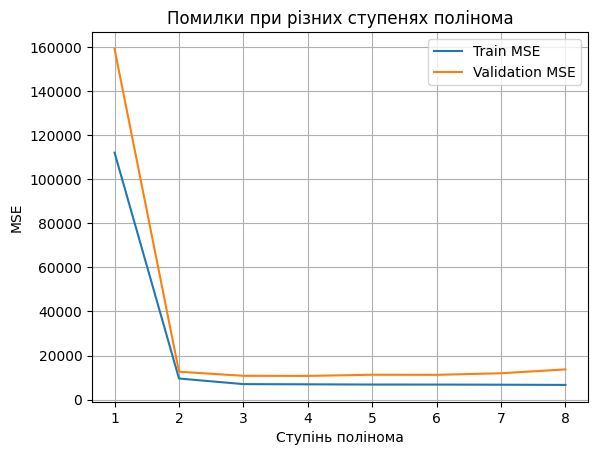

In [7]:
from sklearn.metrics import mean_squared_error

train_errors = []
val_errors = []
degrees = range(1, 9)

for d in degrees:
    model = make_pipeline(PolynomialFeatures(d), Ridge(alpha=0))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_test, y_val_pred))

plt.plot(degrees, train_errors, label="Train MSE")
plt.plot(degrees, val_errors, label="Validation MSE")
plt.xlabel("Ступінь полінома")
plt.ylabel("MSE")
plt.legend()
plt.title("Помилки при різних ступенях полінома")
plt.grid(True)
plt.show()


Визначення оптимального ступеня та застосування регуляризації

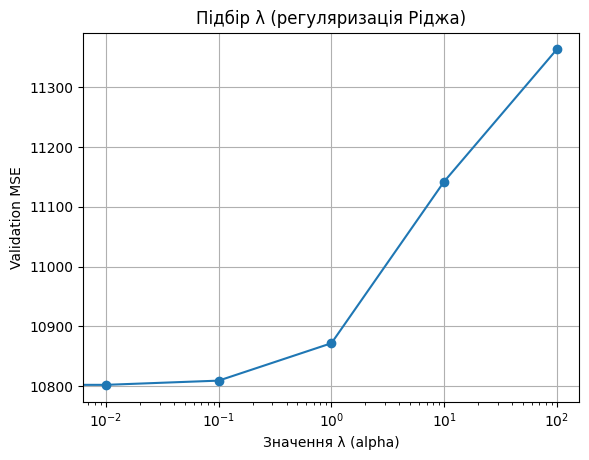

Оптимальний alpha: 0


In [4]:
# Візуально зі графіка вибираємо оптимальний ступінь, наприклад: 3
best_degree = 3

alphas = [0, 0.01, 0.1, 1, 10, 100]
val_errors_ridge = []

for alpha in alphas:
    model = make_pipeline(PolynomialFeatures(best_degree), Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_test)
    val_errors_ridge.append(mean_squared_error(y_test, y_val_pred))

plt.semilogx(alphas, val_errors_ridge, marker='o')
plt.xlabel("Значення λ (alpha)")
plt.ylabel("Validation MSE")
plt.title("Підбір λ (регуляризація Ріджа)")
plt.grid(True)
plt.show()

print("Оптимальний alpha:", alphas[np.argmin(val_errors_ridge)])


Криві навчання для різних моделей

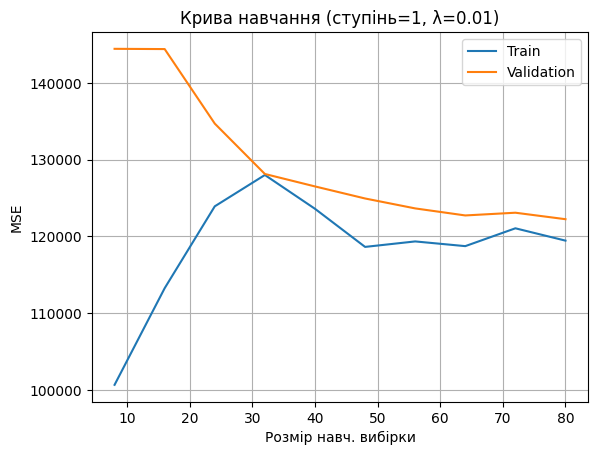

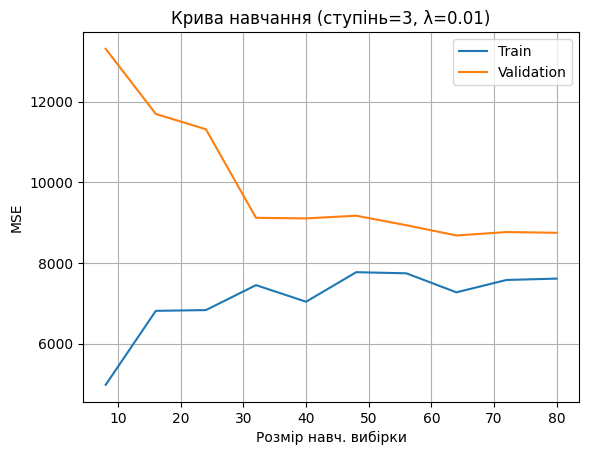

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.3268e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.57135e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.67042e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.38883e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarn

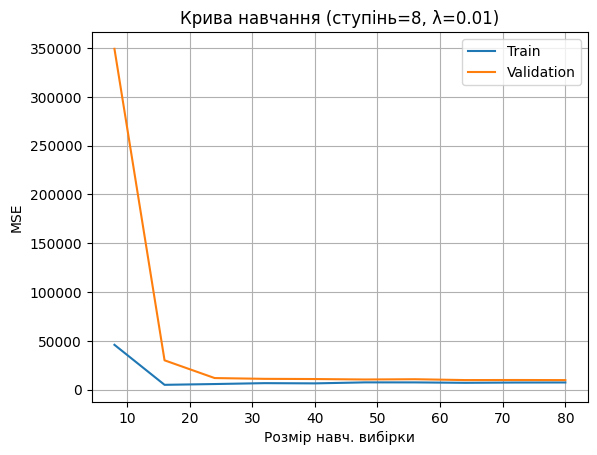

In [5]:
def plot_learning_curve(degree, alpha=0):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y.ravel(), cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = -train_scores.mean(axis=1)
    val_mean = -val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, label="Train")
    plt.plot(train_sizes, val_mean, label="Validation")
    plt.title(f"Крива навчання (ступінь={degree}, λ={alpha})")
    plt.xlabel("Розмір навч. вибірки")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# Для ступенів 1, 3, 8
for d in [1, 3, 8]:
    plot_learning_curve(degree=d, alpha=0.01)
